#### **Import Libraries**

In [1]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import matplotlib.pyplot as plt
from datasets import Dataset
import transformers
from torch.utils.data import DataLoader
import numpy as np 
import torch
from torch import nn
from llmft.train import evaluate_model, train_one_epoch, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict
from llmft.generate import generate_dataset

#### **Set Up Device**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Tokenizer**

In [3]:
model_id = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.model_max_length = 512
print(tokenizer.model_max_length)

def tokenizer_function(example):
  return tokenizer(example["text"], truncation=True)

512


#### **Dataset**

In [4]:
# original_dataset = Dataset.from_dict(generate_dataset(total_entries=1000, flip_rate=0.1))
# dataset = original_dataset.train_test_split(test_size=0.5, seed=42)
# tokenized_dataset = dataset.map(tokenizer_function, batched=True)
# tokenized_dataset = tokenized_dataset.remove_columns("text")

original_dataset = load_dataset("ppower1/instrument")['train']
def check_prefix(example):
    example['type_indicator'] = 1 if example['text'].startswith('Yes') else 0
    return example

def filter_status(example):
    return example['type_indicator'] == 1

original_dataset = original_dataset.map(check_prefix)
# original_dataset = original_dataset.filter(filter_status)
subset_dataset = original_dataset.shuffle(seed=42).select(range(500))
dataset = subset_dataset.train_test_split(test_size=0.5, seed=42)
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['text', 'treated text', 'control text', 'raw_label'])

def count_tokens(example):
    tokens = tokenizer.tokenize(example['text'])
    return {"num_tokens": len(tokens)}

max(dataset['train'].map(count_tokens)['num_tokens'])

638

#### **Hyperparameters**

In [5]:
batch_size = 16
epochs = 20

#### **DataLoaders**

In [6]:
train_loader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

#### **Model**

In [7]:
# labels = tokenized_dataset['train'].features['label'].names

# num_labels = len(labels)
# label2id, id2label = dict(), dict()
# for i, label in enumerate(labels):
#     label2id[label] = str(i)
#     id2label[str(i)] = label 
num_labels=2

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           num_labels=num_labels)
                                                        #    label2id=label2id,
                                                        #    id2label=id2label)
model = model.to(device)
model = torch.compile(model)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Optimizer and scheduler**

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(0.5*len(train_loader)*epochs), len(train_loader)*epochs)

In [10]:
# Assume 'class_counts' is a list containing the number of samples for each class
total_samples = sum(original_dataset['label'])
fraction_treated = sum(original_dataset['type_indicator'])/len(original_dataset)
class_weights = torch.tensor([1/(1-fraction_treated), 1/fraction_treated], device=device)
class_weights = torch.tensor([0.5, 0.5], device=device) #torch.tensor([1-total_treated/ len(original_dataset), total_treated/ len(original_dataset)], device=device)#torch.tensor([total_samples/ len(original_dataset), 1-total_samples/ len(original_dataset)], device=device)
print(f"Relative Weights: {class_weights}")
criterion = FocalLoss(alpha=class_weights, gamma=0., mode='output')

Relative Weights: tensor([0.5000, 0.5000], device='cuda:0')


In [11]:
for batch in test_loader:
    b = batch['type_indicator'].to(device)
    print(b)
    print(class_weights[b])
    break

tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')


#### **Training**

In [12]:
mode = 'input'
evaluation_losses = [evaluate_model(model, test_loader, criterion, device)]
training_losses = [evaluate_model(model, train_loader, criterion, device)]
early_stopping = EarlyStopping(patience=10, verbose=True)
metric_history = []
learning_rate_history = []

for epoch in range(epochs):

    train_loss, (recall, _), current_lr = train_one_epoch(model, train_loader, optimizer, scheduler, compute_recall, criterion, device)

    training_losses.append(train_loss)
    metric_history.append(recall)
    learning_rate_history.append(current_lr)
    
    val_loss = evaluate_model(model, test_loader, criterion, device)
    evaluation_losses.append(val_loss)
    
    # Call early stopping
    early_stopping(val_loss, model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

model.load_state_dict(torch.load('checkpoint.pt'))

/home/ubuntu/llmft/llms/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:124: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Validation loss improved (0.306590). Saving model...
Validation loss improved (0.268569). Saving model...
Validation loss improved (0.134014). Saving model...
Validation loss improved (0.095824). Saving model...
Validation loss improved (0.094065). Saving model...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
Validation loss improved (0.093537). Saving model...
Validation loss improved (0.092957). Saving model...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
Validation loss improved (0.090443). Saving model...
Validation loss improved (0.089762). Saving model...
Validation loss improved (0.085495). Saving model...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
Validation loss improved (0.083795). Saving model...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10


<All keys matched successfully>

In [13]:
metric_history

[tensor([0.9667, 0.0000]),
 tensor([0.9958, 0.0000]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1.0000, 0.1000]),
 tensor([1.0000, 0.1000]),
 tensor([1.0000, 0.2000]),
 tensor([1.0000, 0.2000])]

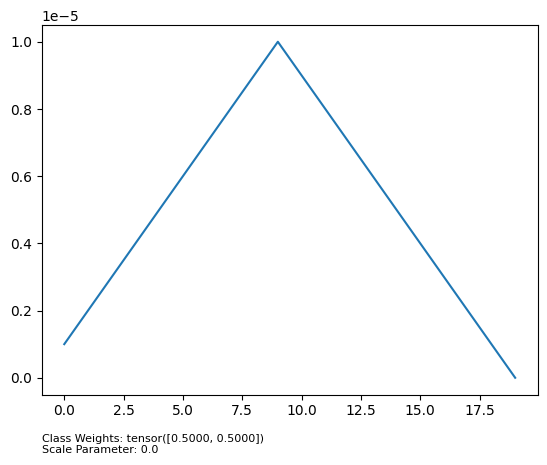

In [14]:
plt.plot(learning_rate_history)
plt.annotate(f'Class Weights: {criterion.alpha.cpu()}',
            xy = (0.0, -0.12),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=8)
plt.annotate(f'Scale Parameter: {criterion.gamma}',
            xy = (0., -0.15),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=8)
plt.show()

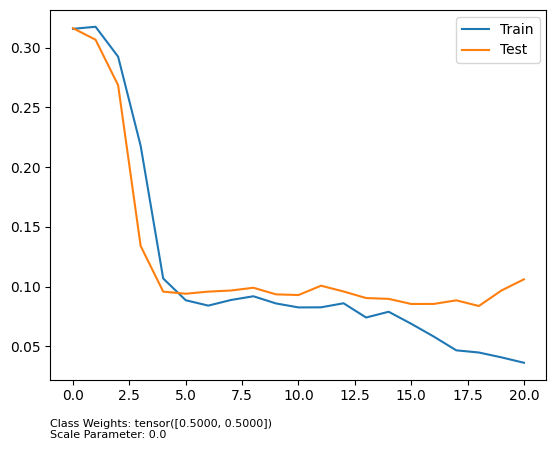

In [15]:
plt.plot(training_losses, label='Train')
plt.plot(evaluation_losses, label='Test')
plt.annotate(f'Class Weights: {criterion.alpha.cpu()}',
            xy = (0.0, -0.12),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=8)
plt.annotate(f'Scale Parameter: {criterion.gamma}',
            xy = (0., -0.15),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=8)
plt.legend()
plt.show()

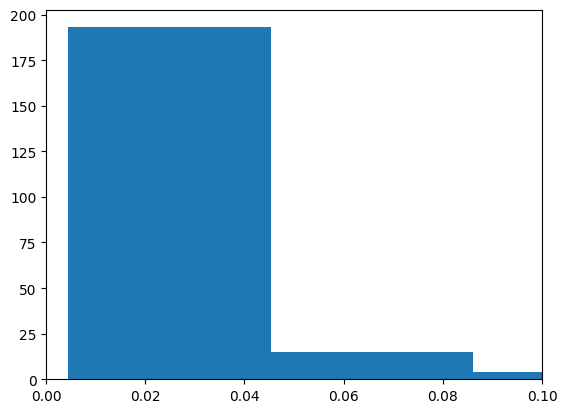

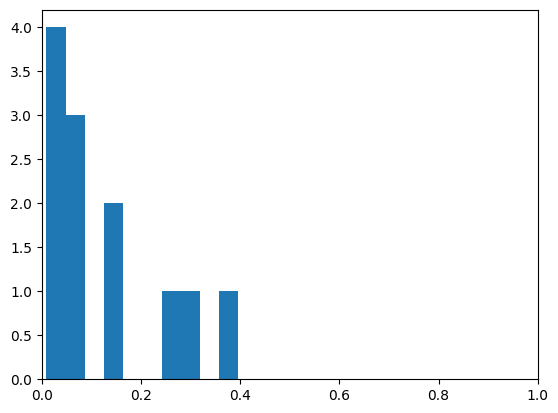

In [16]:
yhat, labels = predict(model, test_loader, device)
plt.hist(yhat[np.array(1-labels).astype(bool)])
plt.xlim(0, .1)
plt.show()
plt.hist(yhat[np.array(labels).astype(bool)])
plt.xlim(0., 1.)
plt.show()